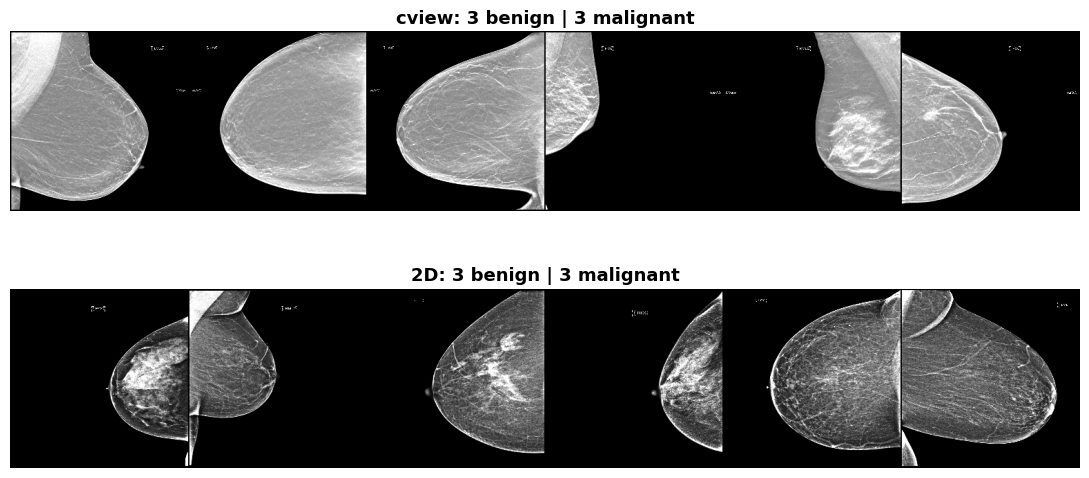

In [2]:
# ── Row viewers for EMBED cview / 2D (3 benign + 3 malignant) ────────────────
import os, glob, random
import numpy as np
import nibabel as nib
import torch
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Paths (your layout)
TRAIN_ROOT  = "/mnt/d/Datasets/EMBED/EMBED_binary_256x256/train"
ROOT_CVIEW  = os.path.join(TRAIN_ROOT, "original_cview")
ROOT_2D     = os.path.join(TRAIN_ROOT, "original_2d")
LABELS = ["benign", "malignant"]

# How many to show per label (left: benign x3, right: malignant x3)
PER_LABEL = 3
RESOLUTION = 256  # only used for figure sizing

# ---- robust NIfTI → PIL loader (always returns 2D) --------------------------
def load_nii_as_pil(path):
    arr = np.asanyarray(nib.load(path).dataobj, dtype=np.float32)

    # Reduce to a single 2D slice:
    if arr.ndim == 4:
        # drop channel/time first if present (take first)
        arr = arr[..., 0]
    if arr.ndim == 3:
        # choose the "depth" axis as the smallest dimension and take its middle slice
        depth_axis = int(np.argmin(arr.shape))
        mid = arr.shape[depth_axis] // 2
        arr = np.take(arr, indices=mid, axis=depth_axis)
    # If any singleton dims remain, squeeze (but keep 2D)
    arr = np.squeeze(arr)
    if arr.ndim != 2:
        raise ValueError(f"Expected 2D after slicing, got shape {arr.shape} for {path}")

    # Contrast-normalize for display (1–99 percentile)
    vmin, vmax = np.percentile(arr, 1), np.percentile(arr, 99)
    if vmax > vmin:
        arr = (arr - vmin) / (vmax - vmin + 1e-8)
    else:
        arr = (arr - arr.min()) / (arr.ptp() + 1e-8)
    arr = np.clip(arr, 0, 1)

    # → 8-bit PIL (L)
    arr8 = (arr * 255).astype(np.uint8)
    return Image.fromarray(arr8, mode="L")

to_tensor = transforms.Compose([
    transforms.ToTensor(),  # [0,1], shape (1,H,W) for grayscale PIL
])

def sample_paths(root_dir, label, k):
    paths = glob.glob(os.path.join(root_dir, label, "*", "slice.nii.gz"))
    if len(paths) < k:
        raise RuntimeError(f"Need at least {k} slices under {root_dir}/{label}, found {len(paths)}.")
    return random.sample(paths, k)

def make_row_tensor(root_dir, k=PER_LABEL):
    """Returns a (2*k, 1, H, W) tensor: [benign*k, malignant*k]"""
    tensors = []
    for label in LABELS:
        for p in sample_paths(root_dir, label, k):
            pil_img = load_nii_as_pil(p)
            tensors.append(to_tensor(pil_img))      # (1,H,W) in [0,1]
    return torch.stack(tensors, dim=0)

# Build rows
row_cview = make_row_tensor(ROOT_CVIEW, PER_LABEL)   # (6,1,H,W)
row_2d    = make_row_tensor(ROOT_2D,    PER_LABEL)   # (6,1,H,W)

# Make grids (left 3 benign, right 3 malignant)
grid_cview = make_grid(row_cview, nrow=6, padding=2, value_range=(0, 1))
grid_2d    = make_grid(row_2d,    nrow=6, padding=2, value_range=(0, 1))

img_cview = grid_cview.permute(1, 2, 0).cpu().numpy()
img_2d    = grid_2d.permute(1, 2, 0).cpu().numpy()

# Plot nicely with titles
fig, axes = plt.subplots(2, 1, figsize=(11, 2.8*2))
axes[0].imshow(img_cview, cmap="gray")
axes[0].axis("off")
axes[0].set_title("cview: 3 benign | 3 malignant", fontsize=13, weight="bold")

axes[1].imshow(img_2d, cmap="gray")
axes[1].axis("off")
axes[1].set_title("2D: 3 benign | 3 malignant", fontsize=13, weight="bold")

plt.tight_layout()
plt.show()
